In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
clientes = pd.read_csv('caso_estudo_clientes.csv', sep=';')
vendas = pd.read_csv('caso_estudo_vendas.csv', sep=';')
produtos = pd.read_csv('caso_estudo_produtos.csv', sep=';')
pagamentos = pd.read_csv('caso_estudo_pagamentos.csv', sep=';')
lojas = pd.read_csv('caso_estudo_lojas.csv', sep=';')

In [40]:
# === LIMPEZA ===

#Ajustando dados nulos
clientes.loc[clientes.nome.isnull(),'nome'] = 'Sem Nome'
clientes.loc[clientes.sexo.isnull(),'sexo'] = 'o'
clientes.loc[clientes.dt_nasc.isnull(),'dt_nasc'] = '1/24/2022'
produtos.loc[9,'valor'] = 3500
produtos.loc[9,'produto'] = 'Monitor Gamer'

#Ajustando Datas
clientes.dt_nasc = pd.to_datetime(clientes.dt_nasc, format='%m/%d/%Y')
vendas.dt_venda = pd.to_datetime(vendas.dt_venda, format='%d/%m/%Y')
pagamentos.dt_pgto = pd.to_datetime(pagamentos.dt_pgto, format='%d/%m/%Y')

#Índices
clientes = clientes.set_index('id')
vendas = vendas.set_index('id')
produtos = produtos.set_index('id')
pagamentos = pagamentos.set_index('id')
lojas = lojas.set_index('id')


In [41]:
# === FUSION ===

lista_geral = vendas.join(clientes.add_prefix('cliente_'), on='id_cliente')
lista_geral = lista_geral.join(produtos.add_prefix('produto_'), on='id_produto')
lista_geral = lista_geral.join(lojas.add_prefix('loja_'), on='id_loja')
lista_geral = lista_geral.join(pagamentos.set_index('id_venda'))

In [42]:
# === FEATURE ENGINEERING ===

# Compras sem pagamento
lista_geral['pagamento'] = 1
lista_geral.loc[lista_geral.dt_pgto.isnull(), 'pagamento'] = 0

# Tempo entre compra e pagamento
lista_geral['tempo_pagamento'] = (lista_geral.dt_pgto - lista_geral.dt_venda).dt.days

# Idade dos Clientes
lista_geral['cliente_idade'] = np.floor((pd.to_datetime('today') - lista_geral.cliente_dt_nasc)/np.timedelta64(1, 'Y'))

# Análise - parte 01

Perguntas para análise:
- Quais lojas mais vendem?
- Quais produtos mais vendem?
- Quais lojas geram maior receita?
- Quais produtos geram maior receita?

## Lojas que mais vendem

In [43]:
'''
Primeiro passo: Descobrir o nome da coluna das lojas
Segudo: Agrupar os dados nos valores desta coluna
obs.: Não imprime os valores, pq retorna uma lista de dataframe (1 por cidade)
'''

lista_geral.groupby('loja_cidade').count()

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,produto_produto,produto_valor,dt_pgto,pagamento,tempo_pagamento,cliente_idade
loja_cidade,,,,,,,,,,,,,
Belo Horizonte,118,118,118,118,118,118,118,118,118,101,118,101,118
Brasília,83,83,83,83,83,83,83,83,83,71,83,71,83
Curitiba,99,99,99,99,99,99,99,99,99,85,99,85,99
Palmas,107,107,107,107,107,107,107,107,107,97,107,97,107
Recife,110,110,110,110,110,110,110,110,110,99,110,99,110
Rio de Janeiro,83,83,83,83,83,83,83,83,83,71,83,71,83
Salvador,99,99,99,99,99,99,99,99,99,88,99,88,99
Santa Catarina,92,92,92,92,92,92,92,92,92,84,92,84,92
São Paulo,114,114,114,114,114,114,114,114,114,70,114,70,114


In [44]:
lista_geral.groupby('loja_cidade').count().produto_produto

loja_cidade
Belo Horizonte    118
Brasília           83
Curitiba           99
Palmas            107
Recife            110
Rio de Janeiro     83
Salvador           99
Santa Catarina     92
São Paulo         114
Vitória            95
Name: produto_produto, dtype: int64

In [45]:
lista_geral[['loja_cidade', 'produto_produto']].groupby('loja_cidade').count()

,produto_produto
loja_cidade,
Belo Horizonte,118
Brasília,83
Curitiba,99
Palmas,107
Recife,110
Rio de Janeiro,83
Salvador,99
Santa Catarina,92
São Paulo,114


In [46]:
# Listar
lista_geral.groupby('loja_cidade').count().produto_produto.sort_values()

loja_cidade
Brasília           83
Rio de Janeiro     83
Santa Catarina     92
Vitória            95
Curitiba           99
Salvador           99
Palmas            107
Recife            110
São Paulo         114
Belo Horizonte    118
Name: produto_produto, dtype: int64

In [47]:
# Listar da oredem
lista_geral.groupby('loja_cidade').count().produto_produto.sort_values(ascending=False)

loja_cidade
Belo Horizonte    118
São Paulo         114
Recife            110
Palmas            107
Curitiba           99
Salvador           99
Vitória            95
Santa Catarina     92
Brasília           83
Rio de Janeiro     83
Name: produto_produto, dtype: int64

In [48]:
# top 3 cidades que vende mais

lista_geral.groupby('loja_cidade').count().produto_produto.sort_values(ascending=False).head(3)

loja_cidade
Belo Horizonte    118
São Paulo         114
Recife            110
Name: produto_produto, dtype: int64

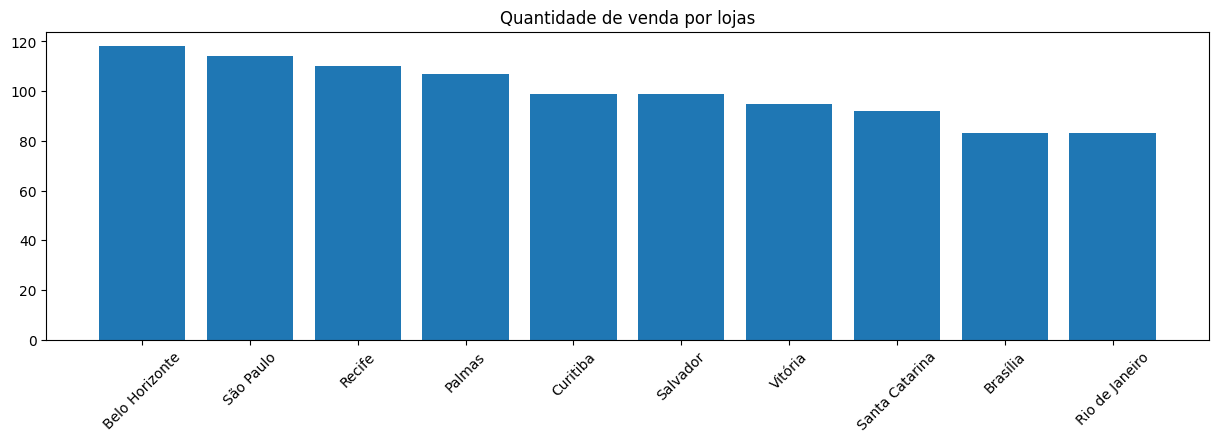

In [49]:
grafico_lojas = lista_geral.groupby('loja_cidade').count().produto_produto.sort_values(ascending=False)

plt.figure(figsize=(15,4))
plt.bar(grafico_lojas.index, grafico_lojas.values)
plt.title('Quantidade de venda por lojas')

# rotaciona os nomes em baixo do grafico
plt.xticks(rotation=45)

plt.show()

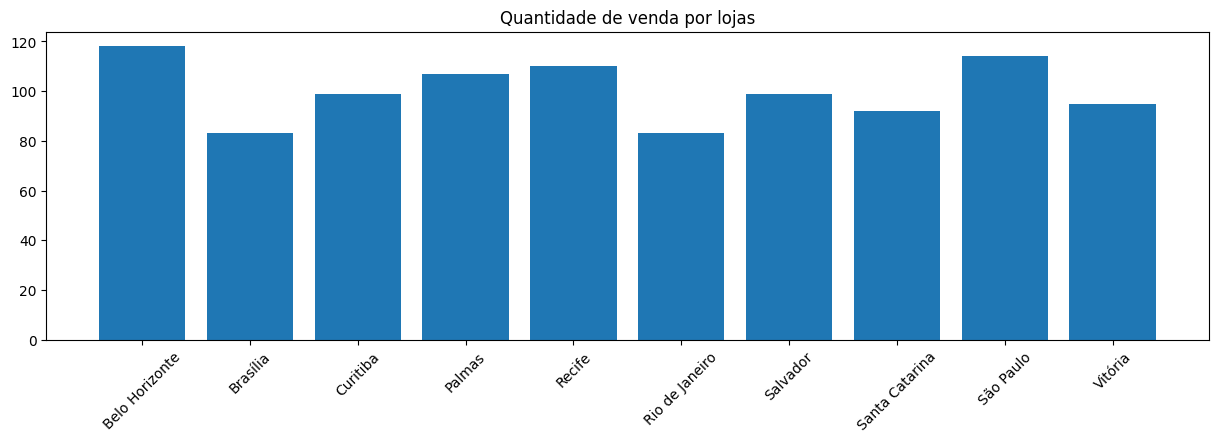

In [50]:
grafico_lojas = lista_geral.groupby('loja_cidade').count().produto_produto

# diminui o nome das cidades em baixo do codigo
plt.figure(figsize=(15,4))

plt.bar(grafico_lojas.index, grafico_lojas.values)
plt.title('Quantidade de venda por lojas')

# rotaciona os nomes em baixo do grafico
plt.xticks(rotation=45)

plt.show()

## Produtos que mais vendem

In [53]:
grafico_lojas = lista_geral.groupby('produto_produto').count().produto_produto

# diminui o nome das cidades em baixo do codigo
plt.figure(figsize=(15,4))

plt.bar(produto_produto.index, produto_produto.values)
plt.title('Quantidade de venda por lojas')

# rotaciona os nomes em baixo do grafico
plt.xticks(rotation=45)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'produto_produto'

## Quais lojas geram maior receita?

## Quais produtos geram maior receita?

In [12]:
lista_geral

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,produto_produto,produto_valor,loja_cidade,dt_pgto,pagamento,tempo_pagamento,cliente_idade
1.0,620,3,2,2018-11-07,Lucas Cardoso,M,1941-10-20,teclado,30.0,Curitiba,2018-11-28,1,21.0,81.0
2.0,483,1,9,2018-01-06,Enzo Goncalves,M,1938-06-01,mesa,860.0,São Paulo,2018-02-12,1,37.0,84.0
3.0,976,8,3,2018-04-10,Emily Correia,F,1951-03-10,laptop básico,2300.0,Brasília,2018-05-23,1,43.0,71.0
4.0,389,5,6,2020-07-05,Marcos Rocha,M,1999-02-04,impressora,700.0,Santa Catarina,2020-07-13,1,8.0,23.0
5.0,626,7,8,2018-07-22,Yasmin Silva,F,1954-08-17,cadeira,540.0,Salvador,2018-08-23,1,32.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.0,641,8,5,2018-03-27,Danilo Cavalcanti,M,1977-07-11,monitor,1500.0,Brasília,2018-05-07,1,41.0,45.0
997.0,325,4,1,2019-07-26,Melissa Cavalcanti,F,1975-06-06,mouse,20.0,Belo Horizonte,2019-09-02,1,38.0,47.0
998.0,765,6,8,2018-03-24,Victor Alves,M,1961-06-21,cadeira,540.0,Recife,2018-04-01,1,8.0,61.0
999.0,217,10,3,2018-08-23,Rafaela Almeida,F,2003-07-25,laptop básico,2300.0,Vitória,NaT,0,NaN,19.0
